In [1]:
# %pip install domolibrary --upgrade


In [2]:
# %pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [3]:
import os
import domolibrary.client.DomoAuth as dmda

auth = dmda.DomoTokenAuth(domo_access_token = os.environ['DOMO_COMMUNITY_TOKEN'], domo_instance= 'domo-community')
await auth.who_am_i()

ResponseGetData(status=200, response={'id': 929336557, 'invitorUserId': 1893952720, 'displayName': 'domo-community-automation', 'userName': 'test279@test.com', 'emailAddress': 'sdk_domo-community@datacrew.space', 'accepted': True, 'userType': 'USER', 'modified': 1739308264563, 'created': 1724421742, 'role': 'Admin', 'rights': 63, 'systemUser': False, 'anonymous': True, 'pending': True, 'active': True}, is_success=True, parent_class=None)

In [4]:
import domolibrary.routes.ai as ai_routes

(await ai_routes.llm_generate_text('why is the sky blue', auth = auth)).response


{'prompt': 'why is the sky blue',
 'choices': [{'output': "The sky appears blue due to a phenomenon called Rayleigh scattering. Here's a simplified explanation:\n\n1. Sunlight contains all colors of the visible spectrum.\n\n2. As sunlight enters Earth's atmosphere, it collides with gas molecules and other particles.\n\n3. These collisions cause the light to scatter in all directions.\n\n4. Blue light has a shorter wavelength and higher frequency than other colors in the visible spectrum.\n\n5. Shorter wavelengths scatter more easily than longer wavelengths.\n\n6. As a result, blue light is scattered more efficiently throughout the atmosphere.\n\n7. This scattered blue light reaches our eyes from all directions, making the sky appear blue.\n\nAt sunrise and sunset, the sky can appear red, orange, or pink because sunlight travels through more of the atmosphere, causing more scattering of blue light. This allows the longer wavelengths (reds and oranges) to become more visible.\n\nIt's wor

In [5]:
import asyncio

class llm:
    auth : dmda.DomoAuth
    model : str

    def __init__(self, auth: dmda.DomoAuth, model : str = None):
        self.auth = auth
        self.model = model

    def invoke(self, message):
        return asyncio.run(ai_routes.llm_generate_text(message = message, auth = auth))
        

In [13]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [6]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()


@tool
def test_python_code_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
) -> dict:  # True if code executes successfully else False
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)

    except BaseException as e:
        return {"is_success" : False, "error" : e}

    
    return {"is_success" : True, "result" : result} 

In [7]:
test_python_code_tool('print("hello world")')

C:\Users\jaewi\AppData\Local\Temp\ipykernel_35804\314868556.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  test_python_code_tool('print("hello world")')
Python REPL can execute arbitrary code. Use with caution.


{'is_success': True, 'result': 'hello world\n'}

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [9]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

supervisor_system_prompt = f"""
You are a supervisor tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""


supervisor_system_prompt

"\nYou are a supervisor tasked with managing a conversation between the following workers: ['researcher', 'coder'].\nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"

In [10]:
from typing import TypedDict

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": supervisor_system_prompt},
    ] + state["messages"]
    response = llm.invoke(messages)
    
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [15]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[test_python_code_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

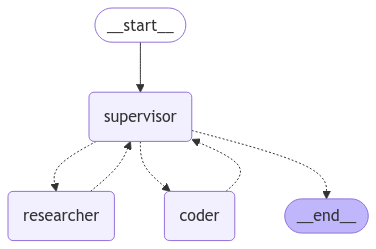

In [16]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'Your credit balance is too low to access the Anthropic API. Please go to Plans & Billing to upgrade or purchase credits.'}}